Assignment: Flowers Recognition <br>
Dataset Description:<br>

This dataset contains 4242 images of flowers.<br>
The data collection is based on the data flicr, google images, yandex images.<br>
You can use this datastet to recognize plants from the photo.<br>

Attribute Information:<br>
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.<br>
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. <br>
<b>Also explore how to resize images in tensorflow and then resize all the images to a same size. </b> <br>
This is a Multiclass Classification Problem.<br>




WORKFLOW : <br>
Load Data <br>
Split into 60 and 40 ratio.<br>
Encode labels.<br>
Create Model<br>
Compilation Step (Note : Its a Multiclass Classification problem , select loss , metrics according to it)<br>
Train the Model.<br>
If the model gets overfit tune your model by changing the units , No. of layers , epochs , add dropout layer or add Regularizer according to the need .<br>
Prediction should be > 85%<br>
Evaluation Step<br>
Prediction<br>




Data : <br>
https://drive.google.com/file/d/1-OX6wn5gA-bJpjPNfSyaYQLz-A-AB_uj/view?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# Importing Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from pathlib import Path
import os
import PIL
import pickle
import cv2
import PIL.Image
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [32]:
# Loading Data And Defining Features And Labels
directory = Path("/content/drive/MyDrive/flowers")

flowers = []
features = []
labels = []

# Iterating Over Directory To Extract Sub Directories
for dir in directory.iterdir():
    flowers.append(dir.name)
    print(dir.name)
# Iterating Over Sub Directories To Extract Lables
    for imgpath in dir.iterdir():
        if imgpath.name.endswith("jpg"):
            labels.append(dir.name)
            imgarr = cv2.imread(str(imgpath), cv2.IMREAD_COLOR)
            imgarr = cv2.resize(imgarr, (150,150))
            features.append(imgarr)

sunflower
daisy
dandelion
tulip
rose


In [39]:
features[5]
labels[5]

'sunflower'

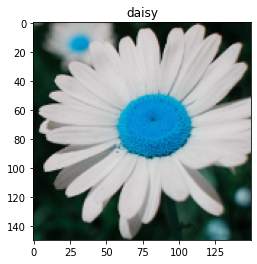

In [11]:
plt.imshow(features[1010])
plt.title(labels[1010])
plt.show()

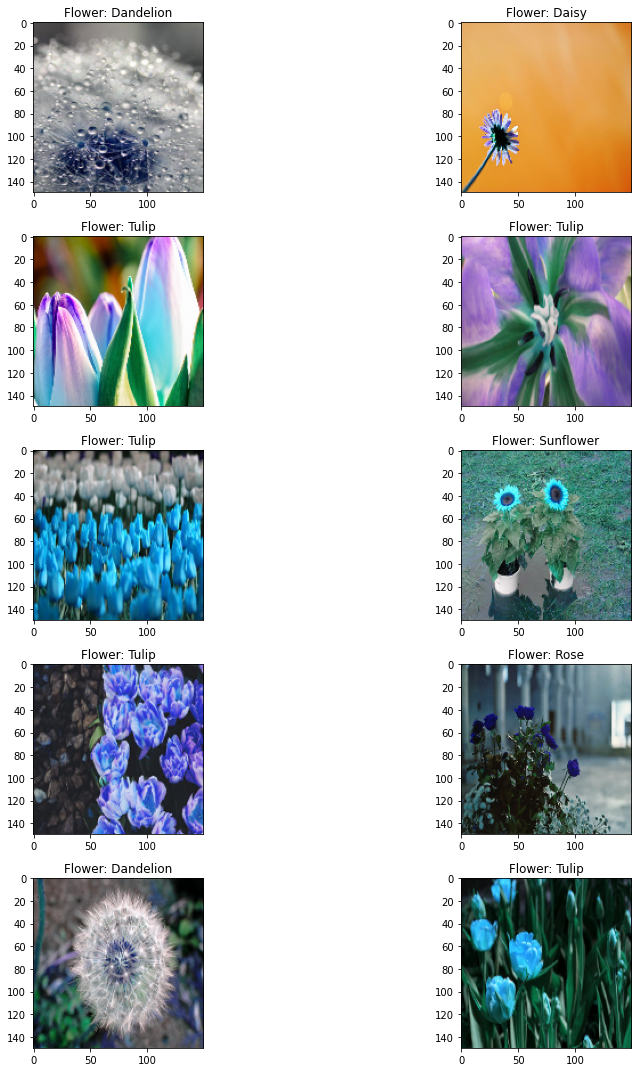

In [23]:
# Visualizing Some Flowers Randomly
import random
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(labels))
        ax[i,j].imshow(features[l])
        ax[i,j].set_title('Flower: '+labels[l].title())
plt.tight_layout()

In [40]:
features = np.array(features)
labels = np.array(labels)
np.savez_compressed("flowers", features, labels)

In [41]:
# One Hot Encoding Labels
labels = LabelEncoder().fit_transform(labels)
labels = to_categorical(labels)
labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [44]:
# Normalizing Features
features = np.array(features)
features = features / 255

In [45]:
# Splitting Into Training And Testing Data: As Per Requirement Splitting Data Into 60 % Training Data And 40 % Testing Data
train_data, train_labels, test_data, test_labels = train_test_split(features, labels, test_size = 0.4, random_state = 42)

In [47]:
# Printing Shape Of Tarining And Testing Data
print(f"Shape Of Train Data: {train_data.shape}")
print(f"Shape of Train Labels: {train_labels.shape}")
print(f"Shape of Test Data: {test_data.shape}")
print(f"Shape of Test Labels: {test_labels.shape}")

Shape Of Train Data: (2595, 150, 150, 3)
Shape of Train Labels: (1730, 150, 150, 3)
Shape of Test Data: (2595, 5)
Shape of Test Labels: (1730, 5)


In [ ]:
# Setting Random Seeds
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [48]:
# Making Base Model
model = Sequential()
model.add(Conv2D(32, kernel_size = (5,5), padding = 'same', activation = 'relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Conv2D(96, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 31104)             0

In [49]:
# Using A LR Annealer
from tensorflow.keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor = 'accuracy', patience = 3, verbose = 1, factor = 0.1)

In [50]:
# Augmenting Data So That We May Not Face Overfitting Problem
DataGen = ImageDataGenerator(
        featurewise_center = False,  
        samplewise_center = False,  
        featurewise_std_normalization = False,  
        samplewise_std_normalization = False,  
        zca_whitening = False,  
        rotation_range = 10, 
        zoom_range = 0.1,  
        width_shift_range = 0.2,  
        height_shift_range = 0.2,  
        horizontal_flip = True,  
        vertical_flip = False)  

DataGen.fit(train_data)

In [51]:
# Compilation Step
model.compile(optimizer=Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [53]:
# Fitting Model On 50 Epochs
history = model.fit_generator(DataGen.flow(train_data, train_labels, batch_size = 128, epochs = 50))

TypeError: ignored